<a href="https://www.kaggle.com/code/maks9213/notebookd33d59b532?scriptVersionId=191635648" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [8]:
from torchvision import transforms, datasets
import torch 

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)

In [9]:
device

'cuda'

In [10]:
root_dir = "/kaggle/input/fruit-recognition/train/train"


In [11]:
dataset = datasets.ImageFolder(root=root_dir)

In [6]:
# from torch.utils.data import random_split

# train_ratio = 0.8


# train_data, test_data = random_split(dataset, [train_ratio, 1-train_ratio])

In [12]:
names = dataset.classes

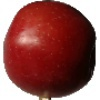

In [13]:
img, label = dataset[0]
img

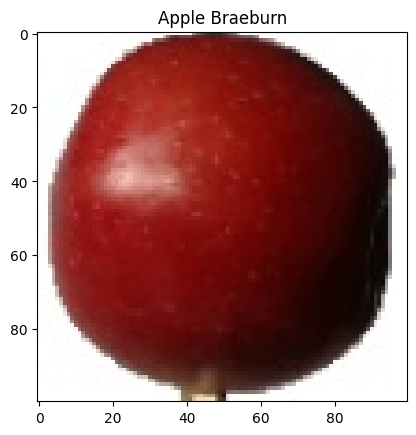

In [14]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 

for i in range(1):
    img, label = dataset[i]
#     img = np.array(img)
#     img = img.transpose(1, 2, 0)
    plt.title(names[label])
    plt.imshow(img)
    plt.show()

In [20]:
len(dataset.classes)

33

In [19]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    
])




In [23]:
data = datasets.ImageFolder(root_dir, transform)
#test_data = datasets.ImageFolder(test_root_dir, test_transform, is_valid_file=lambda path: 'test' in path)

In [24]:
from torch.utils.data import random_split

train_ratio = 0.8

# generator = torch.Generator(device="cpu")
generator = torch.Generator(device=device)

train_data, test_data = random_split(data, [train_ratio, 1-train_ratio], generator=generator)

In [25]:
train_data[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 5)

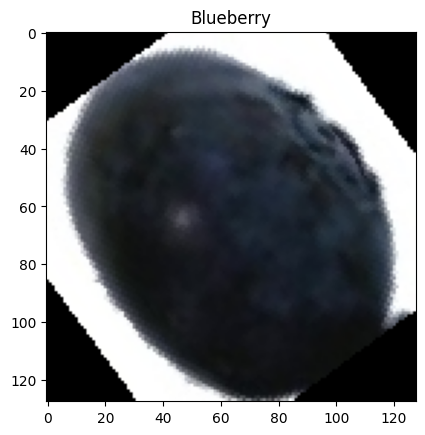

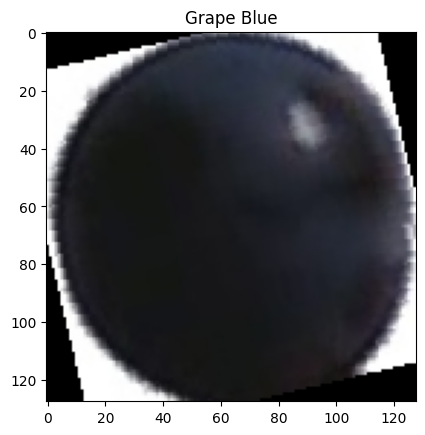

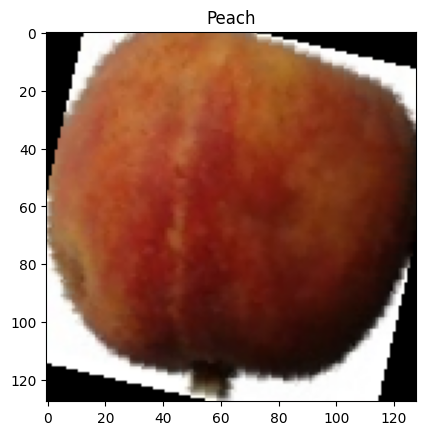

In [26]:
import numpy as np 
import matplotlib.pyplot as plt

def output(dataset, itterations, names_list):
    for i in range(itterations):
        img, label = dataset[i]
        img = np.array(img)
        img = img.transpose(1, 2, 0)
        plt.title(names_list[label])
        plt.imshow(img)
        plt.show()
        
        
output(train_data, 3, names)   


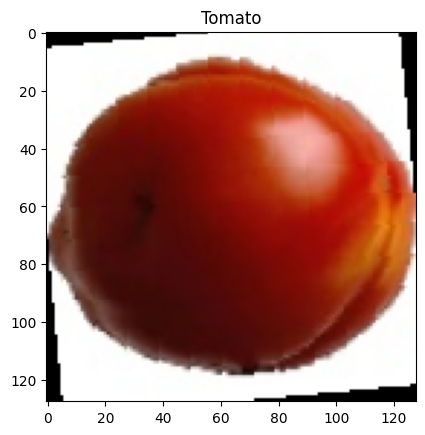

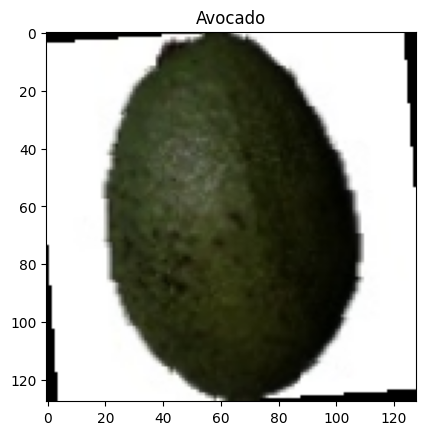

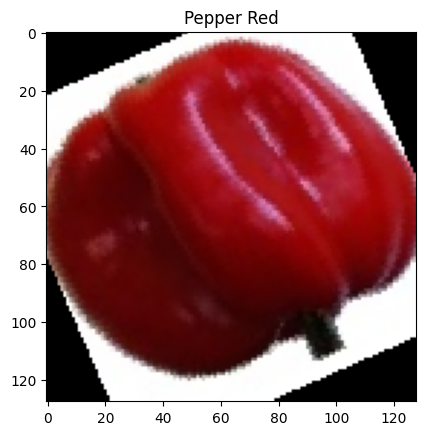

In [27]:
output(test_data, 3, names) 

In [53]:
len(test_data), len(train_data)

(3370, 13484)

In [30]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, generator=torch.Generator(device='cuda'))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, generator=torch.Generator(device='cuda'))

In [28]:
train_data[0][0].shape

torch.Size([3, 128, 128])

In [31]:
train_loader

In [ ]:
# Вихідна ширина = (вхідна ширина - фільтрована ширина + 1) // крок
# Вихідна висота = (вхідна висота - висота фільтра + 1) // крок

In [32]:
from torch import nn 
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, inside_channels, out_channels):
        super().__init__()
#         128, 128, 3
        self.conv1 = nn.Conv2d(in_channels, inside_channels, kernel_size=3)
#     126, 126, 6
        self.conv2 = nn.Conv2d(inside_channels, out_channels, kernel_size=3)
#     124, 124, 12
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
#     62, 62, 12
    
    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.pool1(out)
        out = F.relu(out)
        
        return out
        
    

In [34]:
class ConvNetwork(nn.Module):
    def __init__(self, num_classes=33):
        super().__init__()
#        128, 128, 3
        self.block1 = ConvBlock(3, 6, 12)
#        62, 62, 12
        self.block2 = ConvBlock(12, 18, 24)
#     29, 29, 24
        self.conv1 = nn.Conv2d(24, 24, kernel_size=2)
#     28, 28, 24
        self.block3 = ConvBlock(24, 36, 48)
#     12, 12, 48
        self.block4 = ConvBlock(48, 48, 64)
#       4, 4, 64
        self.conv2 = nn.Conv2d(64, 80, kernel_size=3)
#     2, 2, 80
        self.flatten = nn.Flatten()
#         320
        self.linear1 = nn.Linear(in_features=320, out_features=240)
        self.bnorm1 = nn.BatchNorm1d(num_features=240)
        self.linear2 = nn.Linear(in_features=240, out_features=200)
        self.linear3 = nn.Linear(in_features=200, out_features=150)
        self.linear4 = nn.Linear(in_features=150, out_features=100)
        self.drop1 = nn.Dropout(0.3)
        self.linear5 = nn.Linear(in_features=100, out_features=60)
        self.linear6 = nn.Linear(in_features=60, out_features=40)
        self.linear7 = nn.Linear(in_features=40, out_features=num_classes)

        
    def forward(self, x):
        out = self.block1(x)
        out = self.block2(out)
        out = self.conv1(out)
        out = F.relu(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.conv2(out)
        out = F.relu(out)
        out = self.flatten(out)
        
        out = self.linear1(out)
        out = self.bnorm1(out)
        out = self.linear2(out)
        out = self.linear3(out)
        out = self.linear4(out)
        out = self.drop1(out)
        out = self.linear5(out)
        out = self.linear6(out)
        out = self.linear7(out)
        
        return out
    
    
    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()
        
        

In [35]:
model = ConvNetwork()
model

ConvNetwork(
  (block1): ConvBlock(
    (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ConvBlock(
    (conv1): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(18, 24, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv1): Conv2d(24, 24, kernel_size=(2, 2), stride=(1, 1))
  (block3): ConvBlock(
    (conv1): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(36, 48, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): ConvBlock(
    (conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0

In [36]:
!pip install torchsummary

In [38]:
from torchsummary import summary

summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 126, 126]             168
            Conv2d-2         [-1, 12, 124, 124]             660
         MaxPool2d-3           [-1, 12, 62, 62]               0
         ConvBlock-4           [-1, 12, 62, 62]               0
            Conv2d-5           [-1, 18, 60, 60]           1,962
            Conv2d-6           [-1, 24, 58, 58]           3,912
         MaxPool2d-7           [-1, 24, 29, 29]               0
         ConvBlock-8           [-1, 24, 29, 29]               0
            Conv2d-9           [-1, 24, 28, 28]           2,328
           Conv2d-10           [-1, 36, 26, 26]           7,812
           Conv2d-11           [-1, 48, 24, 24]          15,600
        MaxPool2d-12           [-1, 48, 12, 12]               0
        ConvBlock-13           [-1, 48, 12, 12]               0
           Conv2d-14           [-1, 48,

In [39]:
model.to(device)
model

ConvNetwork(
  (block1): ConvBlock(
    (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): ConvBlock(
    (conv1): Conv2d(12, 18, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(18, 24, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv1): Conv2d(24, 24, kernel_size=(2, 2), stride=(1, 1))
  (block3): ConvBlock(
    (conv1): Conv2d(24, 36, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(36, 48, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block4): ConvBlock(
    (conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(48, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [42]:
from sklearn.metrics import accuracy_score

history = train(model, optimizer, loss_fn, train_loader, test_loader,
                epochs=20,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=ConvNetwork, opt=Adam(lr=0.001000), epochs=20, device=cuda

Epoch    1   79sec	loss:       1.87	val_loss:       1.08	accuracy_score:      0.374	val_accuracy_score:      0.642	
Epoch    2   38sec	loss:      0.986	val_loss:      0.724	accuracy_score:      0.652	val_accuracy_score:      0.754	
Epoch    3   36sec	loss:      0.658	val_loss:      0.379	accuracy_score:      0.775	val_accuracy_score:       0.88	
Epoch    4   36sec	loss:      0.427	val_loss:      0.699	accuracy_score:      0.856	val_accuracy_score:      0.777	
Epoch    5   36sec	loss:      0.327	val_loss:      0.285	accuracy_score:      0.891	val_accuracy_score:      0.908	
Epoch    6   36sec	loss:      0.255	val_loss:      0.122	accuracy_score:      0.915	val_accuracy_score:       0.96	
Epoch    7   37sec	loss:      0.223	val_loss:      0.139	accuracy_score:      0.926	val_accuracy_score:      0.951	
Epoch    8   37sec	loss:       0.18	val_loss:      0.353	accuracy_score:       0.94	val_accuracy_score:   

Text(0.5, 0, 'epoch')

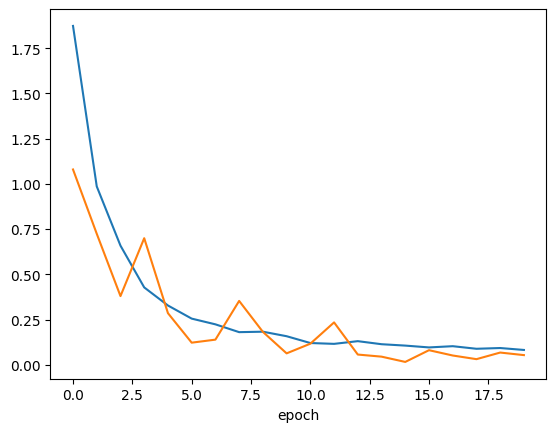

In [43]:
import matplotlib.pyplot as plt 

plt.plot(history["loss"], label="train")
plt.plot(history["val_loss"], label="validation")
plt.xlabel("epoch")

In [44]:
train_data

In [49]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to(device)  

y_pred = model.predict(test_data)

ConfusionMatrixDisplay.from_predictions(y_test, y_pred.argmax(-1))
plt.plot()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (3370, 2) + inhomogeneous part.